# Analyse Background Rates

In [22]:
get_ipython().magic(u'run visualizations.ipynb')
import sys
from hits import CDCHits, CTHHits, CyDetHits
from memory_profiler import memory_usage
from pprint import pprint
from collections import Counter, OrderedDict
sys.path.insert(0, '../modules')
%load_ext memory_profiler
from root_numpy import root2array

Populating the interactive namespace from numpy and matplotlib
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## Import the Signal Hits

In [ ]:
def import_signal_file(file_name):
    cdc_sample = CDCHits(file_name, 
                           tree="CDCHitTree",
                           branches="SmearTime")
    cth_sample = CTHHits(file_name, 
                         tree="CTHHitTree",
                         branches="SmearTime")
    hit_samp = CyDetHits(cdc_sample, cth_sample)
    hit_samp.cth.data[hit_samp.cth.time_name] += \
        hit_samp.cth.data[hit_samp.cth.prefix+"SmearTime"]
    hit_samp.cdc.data[hit_samp.cdc.time_name] += \
        hit_samp.cdc.data[hit_samp.cdc.prefix+"SmearTime"]
    hit_samp.cth.set_trigger_time()
    return hit_samp

In [23]:
file_base = "/home/elg112/ICEDUST_old/track_finding_standalone/"\
            "track_finding_yandex/data/"
file_name = "batch_4_TrkTree_2500.root"
file_name = "batch_3_TrkTree_2536.root"
file_name = "batch_2_TrkTree_2500.root"

back_file = file_base + file_name

In [24]:
# Dictionary of cuts to make as we import
cuts = dict()
# CDC cuts
cuts["cdc"] = dict()
cuts["cdc"]["track"] = "CDCHit.fGoodTrack == 1"
cuts["cdc"]["trigger"] = "CDCHit.fGoodTrig == 1"
cuts["cdc"]["500ns"] = "CDCHit.fDetectedTime < 1620 && "+\
                       "CDCHit.fDetectedTime > 500"
cuts["cdc"]["700ns"] = "CDCHit.fDetectedTime < 1620 && "+\
                       "CDCHit.fDetectedTime > 700"
cuts["cth"] = dict()
cuts["cth"]["track"] = "CTHHit.fGoodTrack == 1"
cuts["cth"]["trigger"] = "CTHHit.fGoodTrig == 1"
cuts["cth"]["500ns"] = "CTHHit.fMCPos.fE < 1620 && "+\
                       "CTHHit.fMCPos.fE > 500"
cuts["cth"]["700ns"] = "CTHHit.fMCPos.fE < 1620 && "+\
                       "CTHHit.fMCPos.fE > 700"

In [25]:
def import_file(file_name, this_cut=None):
    if this_cut is not None:
        cdc_cut = " && ".join([cuts["cdc"][cut] for cut in this_cut])
        cth_cut = " && ".join([cuts["cth"][cut] for cut in this_cut])
    cdc_sample = CDCHits(file_name,
                         selection = cdc_cut,
                         tree="CDCHitTree")
    cth_sample = CTHHits(file_name, 
                         selection = cth_cut,
                         tree="CTHHitTree")
    hit_samp = CyDetHits(cdc_sample, cth_sample)
    hit_samp.cth.set_trigger_time()
    return hit_samp

In [26]:
%%memit
hits = import_file(back_file, this_cut=["500ns"])

peak memory: 1038.58 MiB, increment: 234.18 MiB


In [27]:
print len(np.unique(hits.cth.get_trig_evts()))
print

10


In [28]:
for output, event_list in zip(file_names, events):
    with open(output, mode="w+") as output_file:
        for line in event_list:
            output_file.write("{}\n".format(line))

In [29]:
def get_occupancy(cdc_sample):
    sig_occ, back_occ, occ = list(), list(), list()
    for event in range(cdc_sample.n_events):
        sig_occ += [len(np.unique(cdc_sample.get_signal_hits(event)[cdc_sample.flat_name]))]
        back_occ += [len(np.unique(cdc_sample.get_background_hits(event)[cdc_sample.flat_name]))]
        occ += [len(np.unique(cdc_sample.get_events(event)[cdc_sample.flat_name]))]  
        
    # print some infor
    avg_n_hits = np.average(cdc_sample.event_to_n_hits)
    avg_occ = np.average(occ)
    print "Sig Occ: {} , Back Occ : {}".format(np.average(sig_occ), np.average(back_occ))
    print "All Occ: {}, {}".format(avg_occ, avg_occ/4482.)
    print "NumHits: {}".format(avg_n_hits)
    print "MinChansMultiHit: {}".format((avg_n_hits - avg_occ)/float(avg_occ))
    
    return sig_occ, back_occ, occ

In [31]:
sig_occ, back_occ, occ = get_occupancy(hits.cdc)

Sig Occ: 0.331462925852 , Back Occ : 602.571142285
All Occ: 602.844088176, 0.134503366394
NumHits: 688.456513026
MinChansMultiHit: 0.14201420654


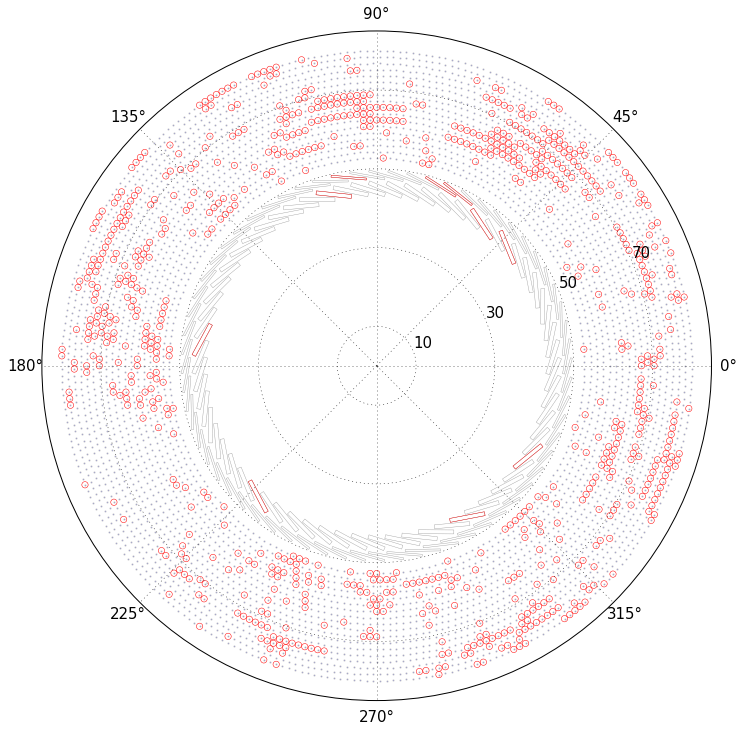

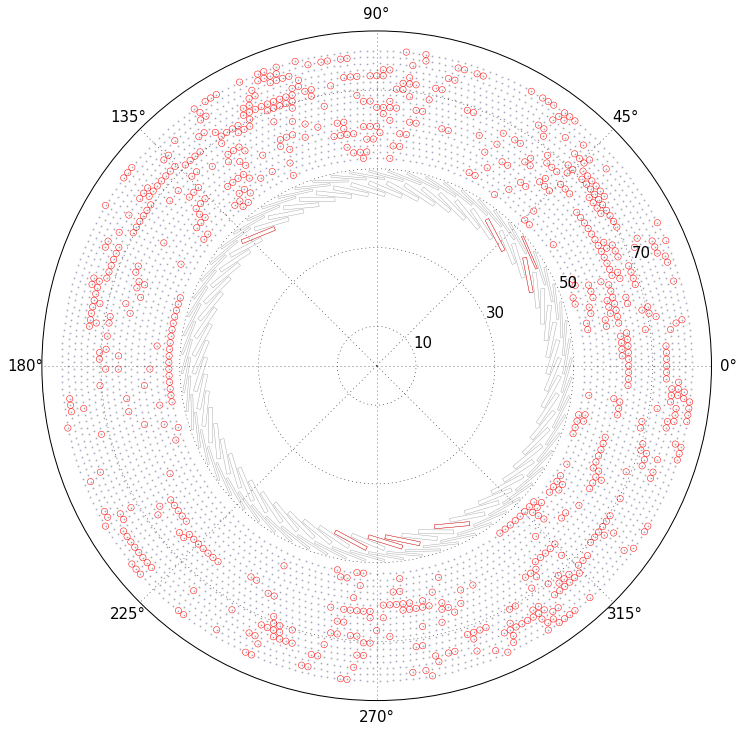

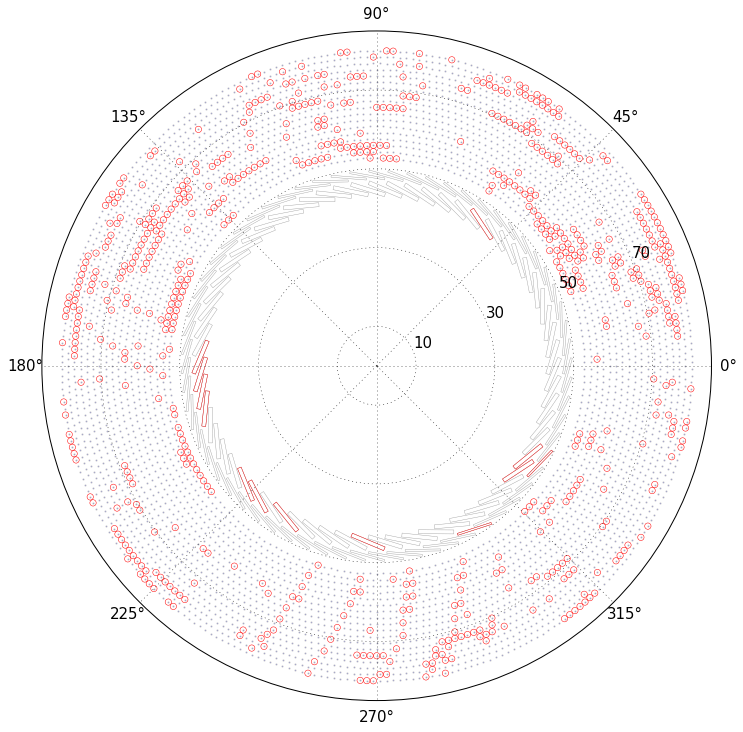

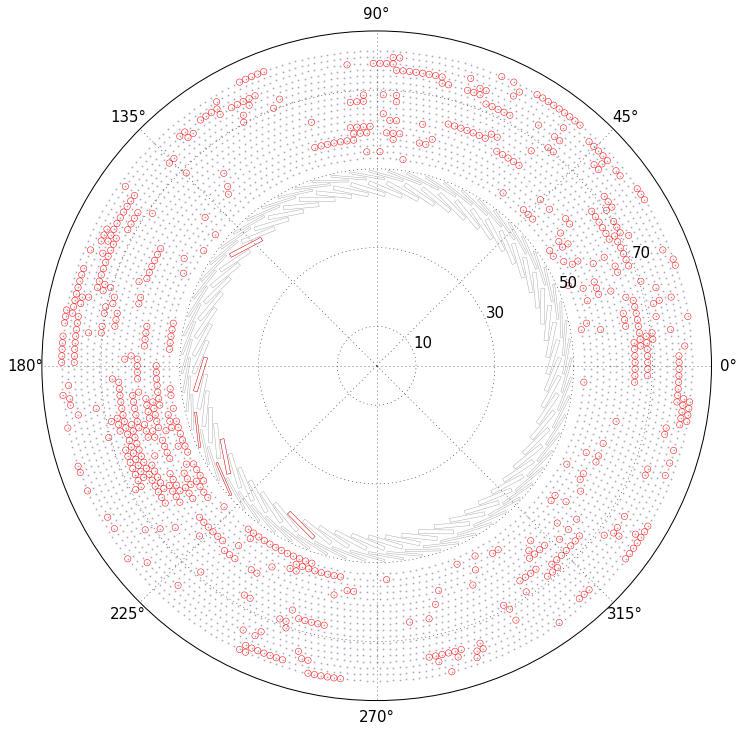

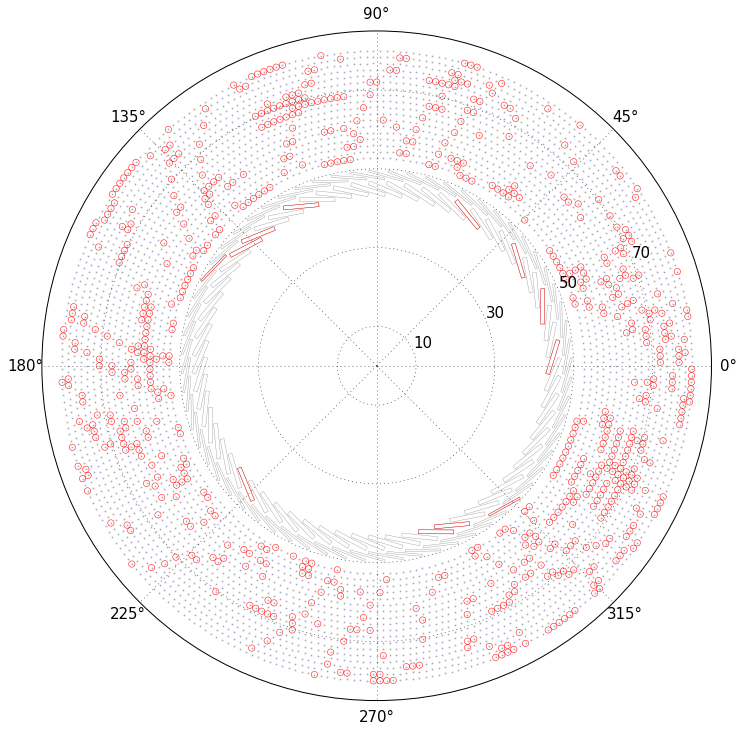

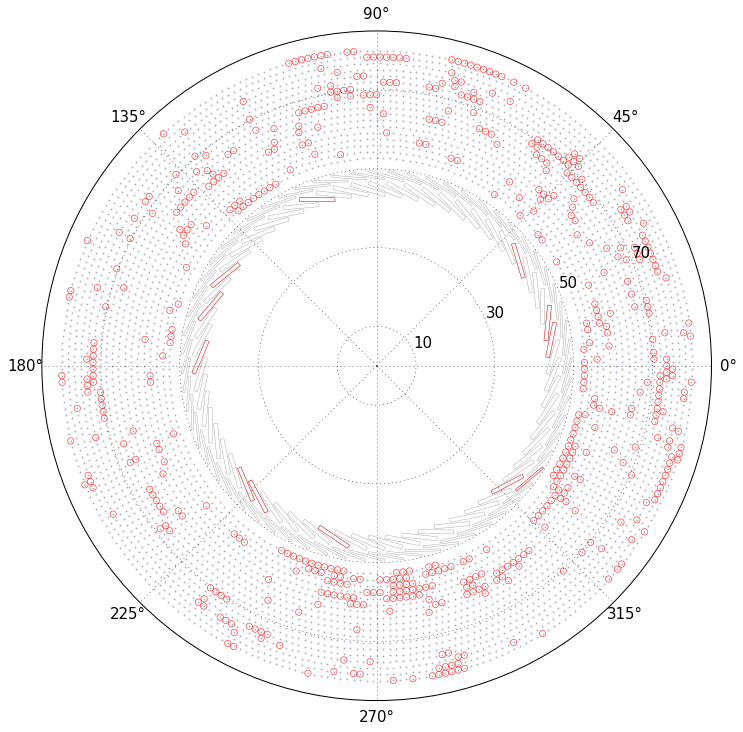

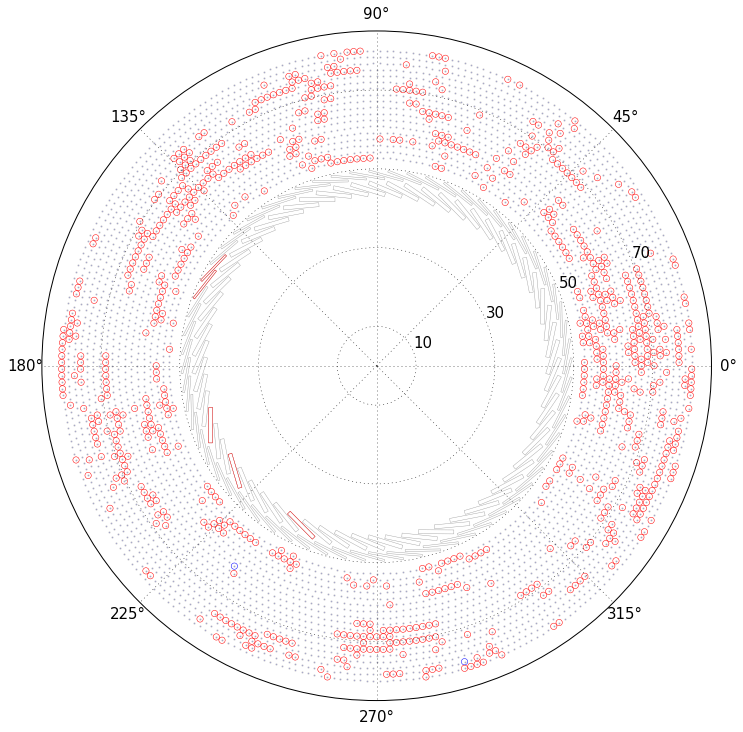

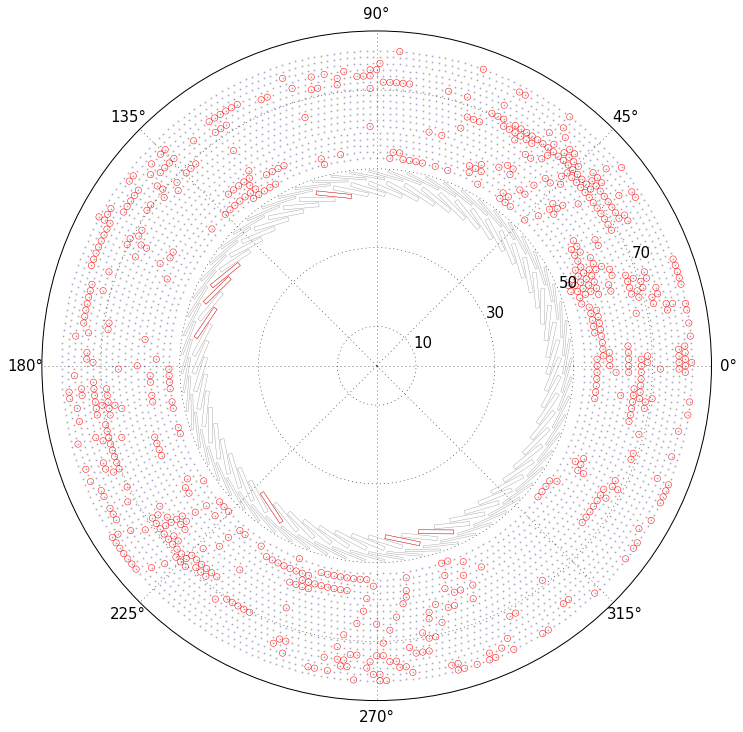

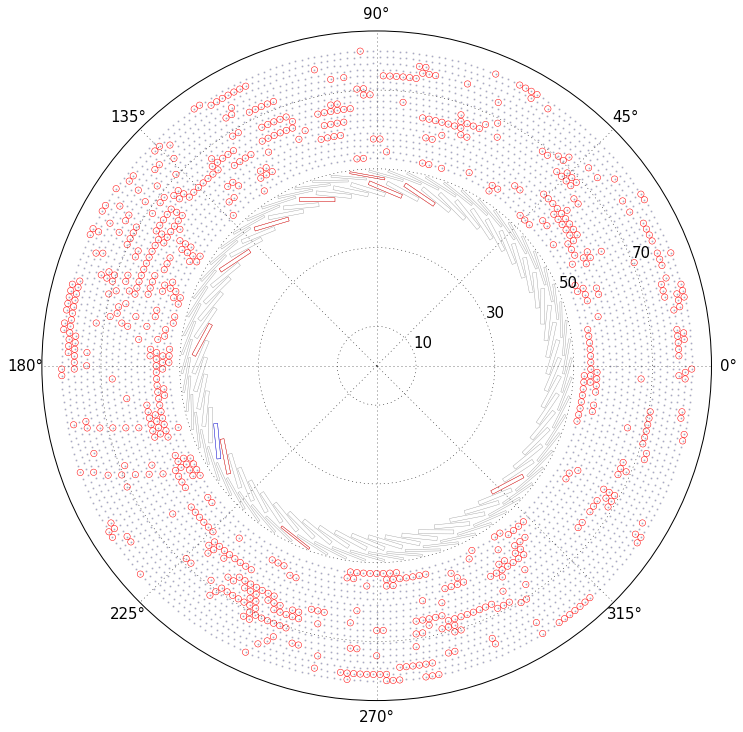

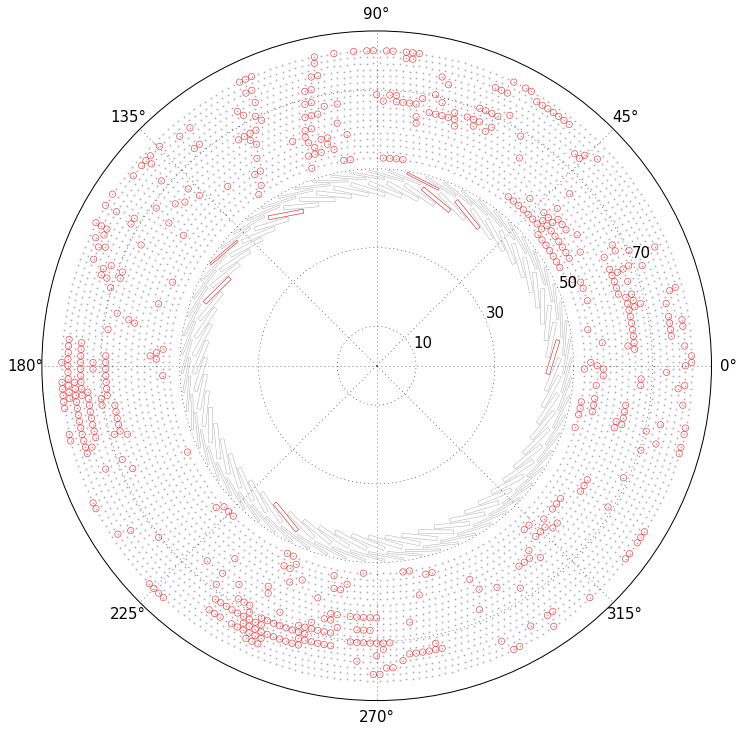

In [32]:
for evt in range(10):
    # Plot the output
    plot_output(np.zeros_like(hits.cdc.get_hit_types(evt)), hits.cdc.geom)
    # Add hit outlines
    plot_add_outlines(hits.cdc.get_hit_types(evt), hits.cdc.geom)
    # Add volume outlines
    plot_add_cth_outlines(hits.cth.geom)
    # Add the CTH vols with hits
    cth_vol_types = hits.cth.get_vol_types(evt)
    plot_add_cth(cth_vol_types, hits.cth.get_trig_vector(evt)[0], hits.cth.geom)
    cth_hits = hits.cth.get_events(evt)
    cdc_hits = hits.cdc.get_signal_hits(evt)
    #plt.scatter(cth_hits[x_pos_name], cth_hits[y_pos_name], s=1, transform=gca().transData._b)
    #plt.scatter(cdc_hits[cdc_x_pos_name], cdc_hits[cdc_y_pos_name], s=1, transform=gca().transData._b)
    plt.show()